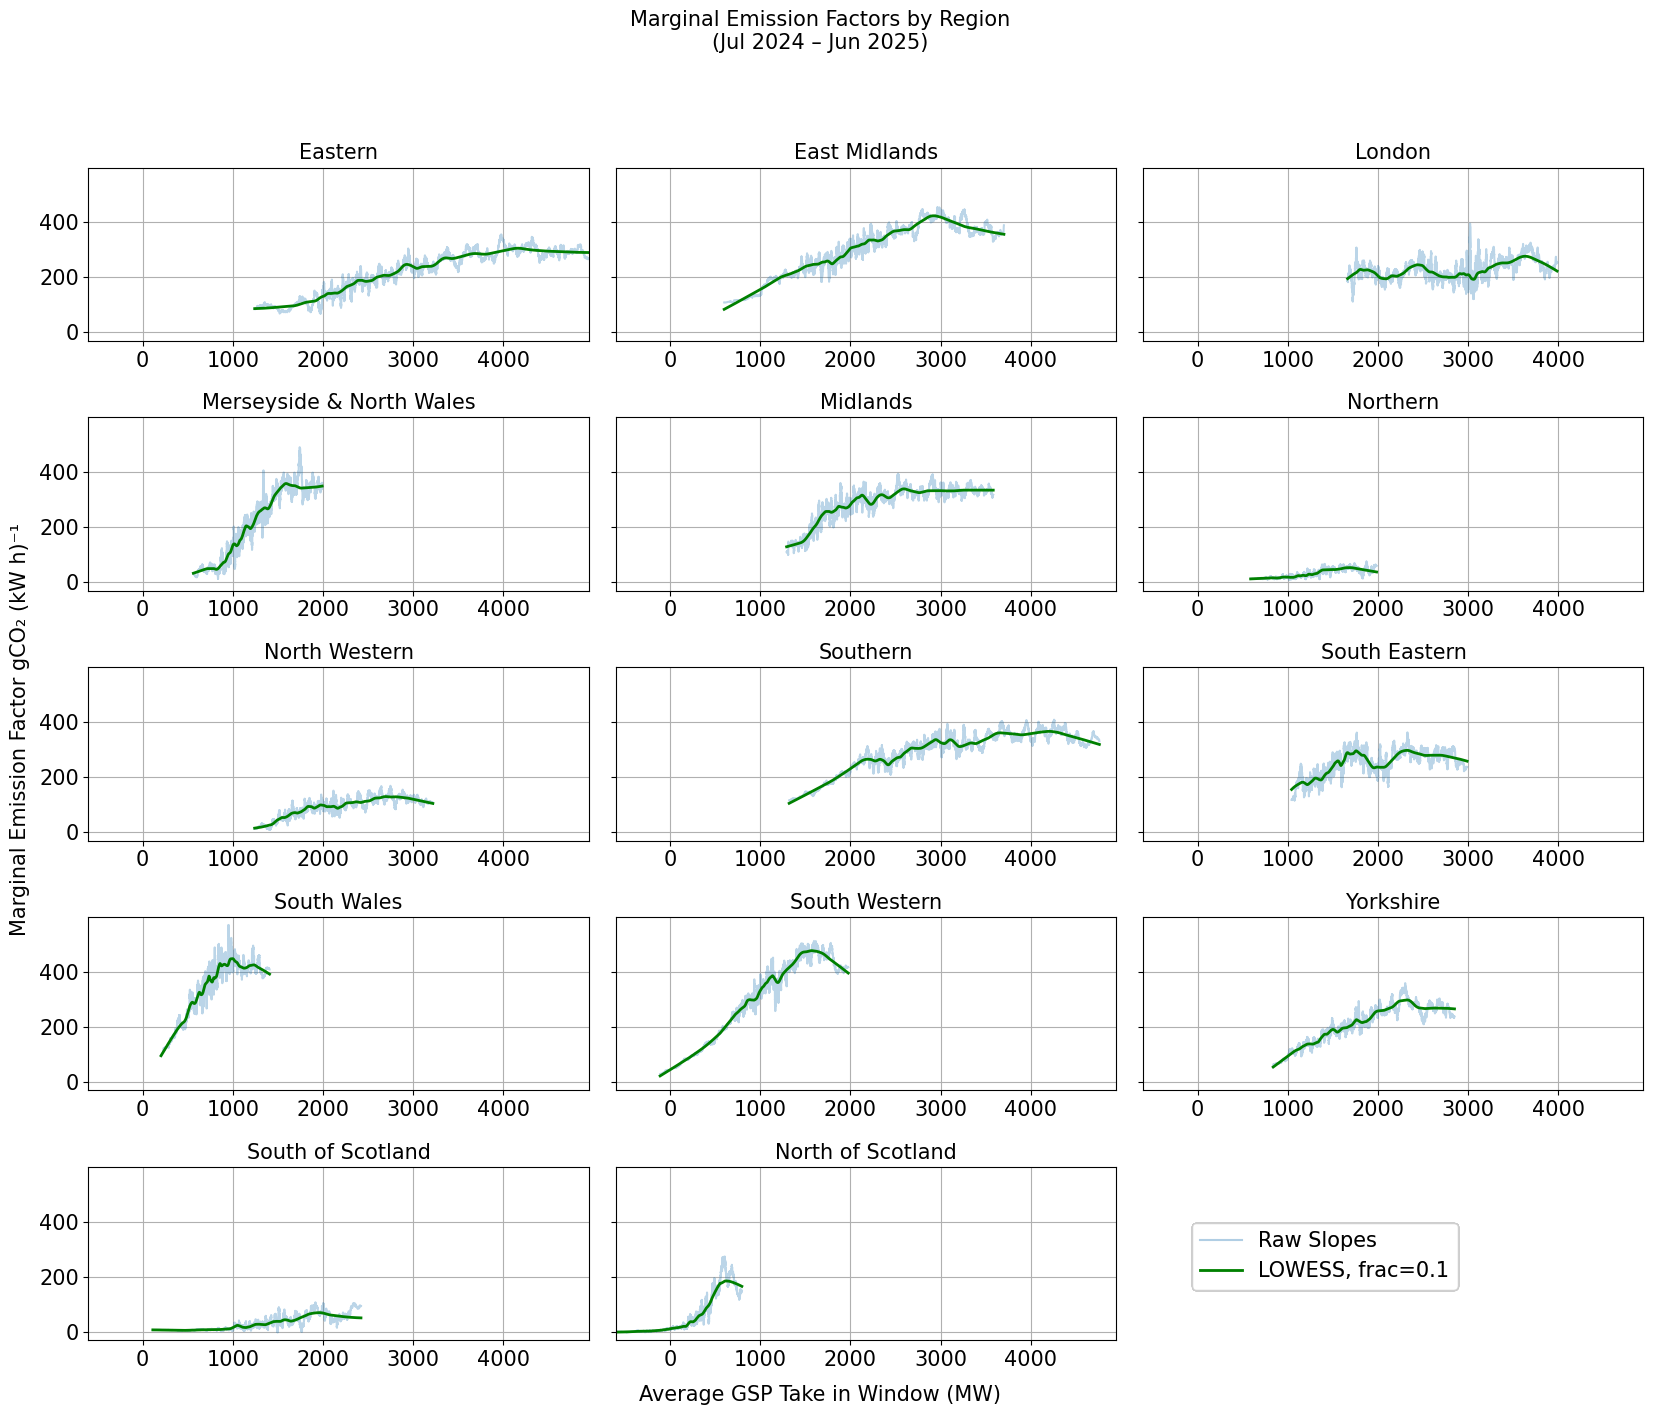

In [5]:
#This is the updated version that handles missing data better and also standardises the x-axis of plots and uses average rather than medians for demand
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# === GLOBAL FONT SIZES (min 15) ===
plt.rcParams.update({
    "font.size": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort (DST-safe prep)
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)  # robust
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

# === Region codes and descriptions ===
region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# === Parameters ===
window_size = 200
lowess_frac = 0.1

# === Compute rolling slopes & means per region (DST-safe forward diffs) ===
region_results = {}  # code -> (means_array, slopes_array)

for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col not in df.columns or ci_col not in df.columns:
        print(f"Skipping {code} (columns missing)")
        continue

    # Bring in date/period and compute forward deltas (t -> t+1) with DST-safe consecutiveness
    region_df = df[['datetime', 'SettlementDate', 'SettlementPeriod', take_col, ci_col]].dropna().copy()
    region_df.rename(columns={take_col: 'Take', ci_col: 'CI'}, inplace=True)
    region_df = region_df.sort_values(['SettlementDate', 'SettlementPeriod'])

    region_df['CO2'] = region_df['Take'] * region_df['CI']

    # Identify true consecutive forward pairs (handles 46/48/50 SP days)
    region_df['next_date'] = region_df['SettlementDate'].shift(-1)
    region_df['next_sp']   = region_df['SettlementPeriod'].shift(-1)
    region_df['max_sp_today'] = region_df.groupby('SettlementDate')['SettlementPeriod'].transform('max')

    same_day_next = (
        (region_df['next_date'] == region_df['SettlementDate']) &
        (region_df['next_sp'] == region_df['SettlementPeriod'] + 1)
    )
    wrap_new_day = (
        (region_df['next_date'] != region_df['SettlementDate']) &
        (region_df['SettlementPeriod'] == region_df['max_sp_today']) &
        (region_df['next_sp'] == 1)
    )
    consecutive_forward = same_day_next | wrap_new_day

    # Forward differences aligned to t+1
    region_df['Δ_Take'] = region_df['Take'].shift(-1) - region_df['Take']
    region_df['Δ_CO2']  = region_df['CO2'].shift(-1) - region_df['CO2']

    # Keep only valid consecutive forward pairs
    region_df = region_df[consecutive_forward].dropna(subset=['Δ_Take', 'Δ_CO2', 'Take']).copy()
    region_df.rename(columns={'Take': 'Take_t'}, inplace=True)

    # Sort by Take_t so rolling windows are by load level (not by time)
    region_df = region_df.sort_values('Take_t').reset_index(drop=True)

    # Rolling OLS slopes of ΔCO2 on ΔTake vs. mean Take_t in the window
    slopes, means = [], []
    if len(region_df) >= window_size:
        for i in range(len(region_df) - window_size + 1):
            window = region_df.iloc[i:i + window_size]
            x = window['Δ_Take'].to_numpy().reshape(-1, 1)
            y = window['Δ_CO2'].to_numpy().reshape(-1, 1)
            reg = LinearRegression(fit_intercept=False).fit(x, y)  # through origin
            slopes.append(reg.coef_[0, 0])

            # Mean of Take_t, converted from MWh/HH to MW via ×2
            means.append(float(window['Take_t'].mean() * 2))

    if len(slopes) > 0:
        region_results[code] = (np.array(means), np.array(slopes))
    else:
        print(f"Skipping {code} (insufficient consecutive data for rolling windows)")

# === Standardise x-axis across all subplots ===
if not region_results:
    raise RuntimeError("No region produced results. Check data availability and window_size.")

all_means = np.concatenate([m for m, _ in region_results.values()])
x_min, x_max = np.min(all_means), np.max(all_means)

# === Plot with shared, standardised x-axis ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharey=True)
axes = axes.flatten()

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    if code not in region_results:
        ax.set_visible(False)
        continue

    means, slopes = region_results[code]
    # LOWESS smoothing for display
    lowess_result = sm.nonparametric.lowess(slopes, means, frac=lowess_frac)

    ax.plot(means, slopes, alpha=0.3, label='Raw Slopes')
    ax.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='LOWESS, frac=0.1')
    ax.set_title(region_descriptions[code], fontsize=15)
    ax.set_xlim(x_min, x_max)  # <- standardised x-axis
    ax.grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.86, 0.12), fontsize=15, frameon=True)

# Hide any unused subplot
for j in range(len(region_codes), len(axes)):
    axes[j].axis('off')

# Shared axis labels and title
fig.supxlabel('Average GSP Take in Window (MW)', fontsize=15, y=0.05)
fig.supylabel('Marginal Emission Factor gCO₂ (kW h)⁻¹', fontsize=15, x=0.05)
fig.suptitle('Marginal Emission Factors by Region\n(Jul 2024 – Jun 2025)', fontsize=15)

plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()


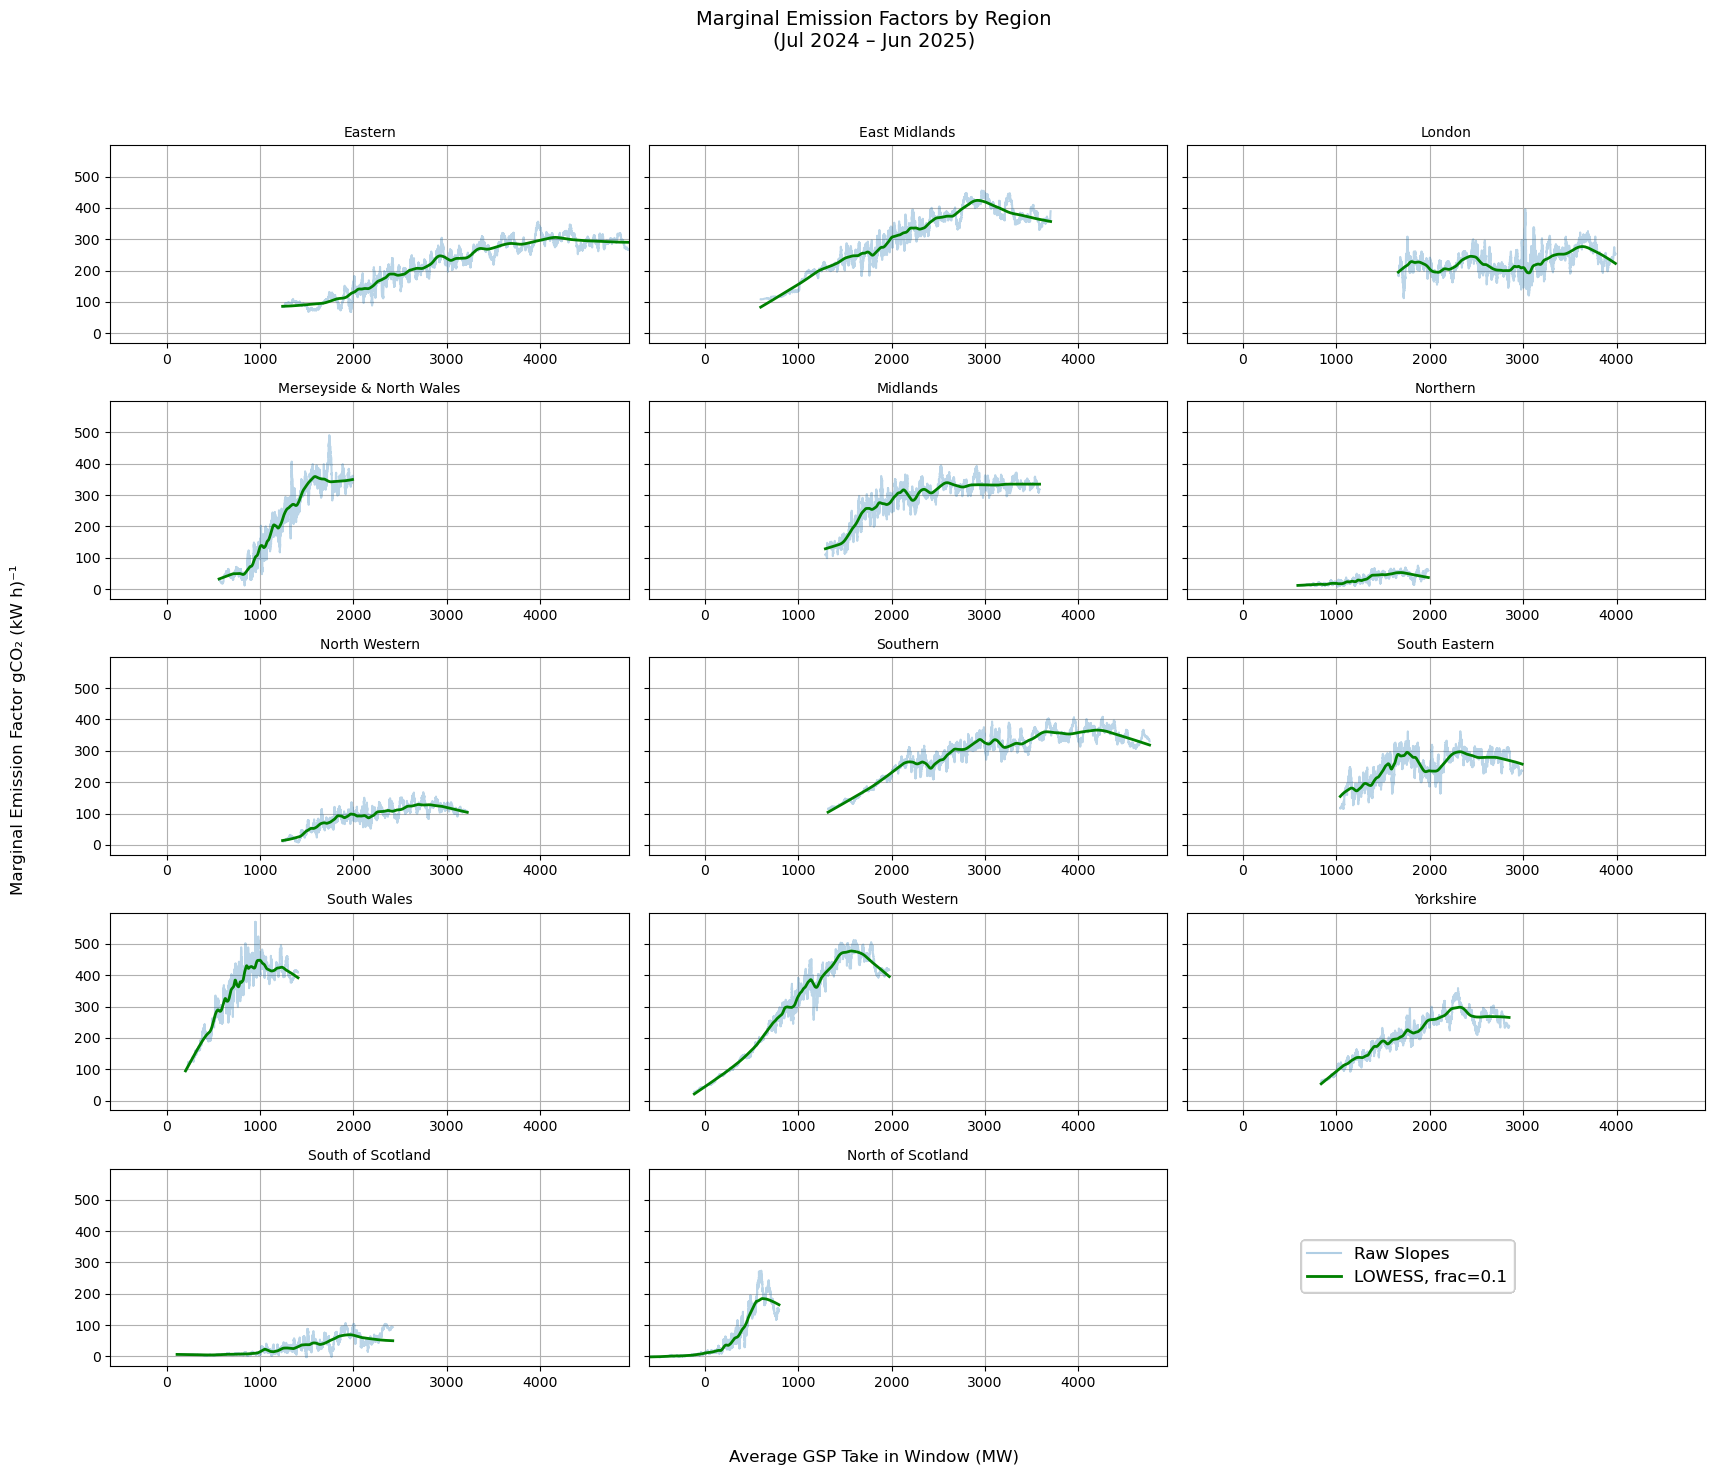

In [14]:
#This is the updated version that handles missing data better and also standardises the x-axis of plots and uses average rather than medians for demand
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort (DST-safe prep)
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)  # robust
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

# === Region codes and descriptions ===
region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# === Parameters ===
window_size = 200
lowess_frac = 0.1

# === Compute rolling slopes & means per region (DST-safe forward diffs) ===
region_results = {}  # code -> (means_array, slopes_array)

for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col not in df.columns or ci_col not in df.columns:
        print(f"Skipping {code} (columns missing)")
        continue

    # Bring in date/period and compute forward deltas (t -> t+1) with DST-safe consecutiveness
    region_df = df[['datetime', 'SettlementDate', 'SettlementPeriod', take_col, ci_col]].dropna().copy()
    region_df.rename(columns={take_col: 'Take', ci_col: 'CI'}, inplace=True)
    region_df = region_df.sort_values(['SettlementDate', 'SettlementPeriod'])

    region_df['CO2'] = region_df['Take'] * region_df['CI']

    # Identify true consecutive forward pairs (handles 46/48/50 SP days)
    region_df['next_date'] = region_df['SettlementDate'].shift(-1)
    region_df['next_sp']   = region_df['SettlementPeriod'].shift(-1)
    region_df['max_sp_today'] = region_df.groupby('SettlementDate')['SettlementPeriod'].transform('max')

    same_day_next = (
        (region_df['next_date'] == region_df['SettlementDate']) &
        (region_df['next_sp'] == region_df['SettlementPeriod'] + 1)
    )
    wrap_new_day = (
        (region_df['next_date'] != region_df['SettlementDate']) &
        (region_df['SettlementPeriod'] == region_df['max_sp_today']) &
        (region_df['next_sp'] == 1)
    )
    consecutive_forward = same_day_next | wrap_new_day

    # Forward differences aligned to t+1
    region_df['Δ_Take'] = region_df['Take'].shift(-1) - region_df['Take']
    region_df['Δ_CO2']  = region_df['CO2'].shift(-1) - region_df['CO2']

    # Keep only valid consecutive forward pairs
    region_df = region_df[consecutive_forward].dropna(subset=['Δ_Take', 'Δ_CO2', 'Take']).copy()
    region_df.rename(columns={'Take': 'Take_t'}, inplace=True)

    # Sort by Take_t so rolling windows are by load level (not by time)
    region_df = region_df.sort_values('Take_t').reset_index(drop=True)

    # Rolling OLS slopes of ΔCO2 on ΔTake vs. mean Take_t in the window
    slopes, means = [], []
    if len(region_df) >= window_size:
        for i in range(len(region_df) - window_size + 1):
            window = region_df.iloc[i:i + window_size]
            x = window['Δ_Take'].to_numpy().reshape(-1, 1)
            y = window['Δ_CO2'].to_numpy().reshape(-1, 1)
            reg = LinearRegression(fit_intercept=False).fit(x, y)  # through origin
            slopes.append(reg.coef_[0, 0])

            # Mean of Take_t, converted from MWh/HH to MW via ×2
            means.append(float(window['Take_t'].mean() * 2))

    if len(slopes) > 0:
        region_results[code] = (np.array(means), np.array(slopes))
    else:
        print(f"Skipping {code} (insufficient consecutive data for rolling windows)")

# === Standardise x-axis across all subplots ===
if not region_results:
    raise RuntimeError("No region produced results. Check data availability and window_size.")

all_means = np.concatenate([m for m, _ in region_results.values()])
x_min, x_max = np.min(all_means), np.max(all_means)

# === Plot with shared, standardised x-axis ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharey=True)
axes = axes.flatten()

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    if code not in region_results:
        ax.set_visible(False)
        continue

    means, slopes = region_results[code]
    # LOWESS smoothing for display
    lowess_result = sm.nonparametric.lowess(slopes, means, frac=lowess_frac)

    ax.plot(means, slopes, alpha=0.3, label='Raw Slopes')
    ax.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='LOWESS, frac=0.1')
    ax.set_title(region_descriptions[code], fontsize=10)
    ax.set_xlim(x_min, x_max)  # <- standardised x-axis
    ax.grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.86, 0.12), fontsize=12, frameon=True)

# Hide any unused subplot
for j in range(len(region_codes), len(axes)):
    axes[j].axis('off')

# Shared axis labels and title
fig.supxlabel('Average GSP Take in Window (MW)', fontsize=12)
fig.supylabel('Marginal Emission Factor gCO₂ (kW h)⁻¹', fontsize=12)
fig.suptitle('Marginal Emission Factors by Region\n(Jul 2024 – Jun 2025)', fontsize=14)

plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()


In [ ]:
#Note, there are more than expected 200 values falling outside the LOWESS range because interpolated LOWESS fitted to all Take, BUT...
#  not all Take used to calculated LOWESS because of missing carbon intensity figures - smaller subset implies smaller range of values
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- Assumes these are already in memory from your previous run:
# df, region_codes, region_results
# If lowess_frac isn't defined, default to 0.15
try:
    lowess_frac
except NameError:
    lowess_frac = 0.1

# 1) Build LOWESS lookup per region (x is MEAN Take in MW; already ×2 earlier)
lowess_by_region = {}  # code -> (x_lowess, y_lowess)

for code in region_codes:
    if code not in region_results:
        continue
    means_MW, slopes = region_results[code]  # means are already in MW
    if len(means_MW) < 2:
        continue

    # LOWESS on (mean MW, slopes)
    low = sm.nonparametric.lowess(slopes, means_MW, frac=lowess_frac, return_sorted=True)
    x_lowess = np.asarray(low[:, 0], dtype=float)
    y_lowess = np.asarray(low[:, 1], dtype=float)

    # Sort (stable) and collapse duplicate x by averaging y
    order = np.argsort(x_lowess, kind="mergesort")
    x_lowess = x_lowess[order]
    y_lowess = y_lowess[order]

    xu, inv = np.unique(x_lowess, return_inverse=True)
    if xu.size != x_lowess.size:
        sums = np.bincount(inv, weights=y_lowess)
        counts = np.bincount(inv)
        y_lowess = sums / np.maximum(counts, 1)
        x_lowess = xu

    lowess_by_region[code] = (x_lowess, y_lowess)

# 2) Interpolation with NaN-safety and edge handling
def interp_with_bounds_nan_safe(x_vals, x_lowess, y_lowess, extrapolate="clip"):
    """
    x_vals: query in MW (to match the means in region_results)
    extrapolate: "clip" for flat ends, "linear" for linear end extrapolation
    """
    x_vals = np.asarray(x_vals, dtype=float)
    out = np.full_like(x_vals, np.nan, dtype=float)

    valid = ~np.isnan(x_vals)
    if not np.any(valid):
        return out

    xv = x_vals[valid]
    y = np.interp(xv, x_lowess, y_lowess)

    x_min, x_max = x_lowess[0], x_lowess[-1]
    if extrapolate == "linear" and len(x_lowess) >= 2:
        below = xv < x_min
        above = xv > x_max
        if np.any(below):
            mL = (y_lowess[1] - y_lowess[0]) / (x_lowess[1] - x_lowess[0])
            y[below] = y_lowess[0] + mL * (xv[below] - x_min)
        if np.any(above):
            mR = (y_lowess[-1] - y_lowess[-2]) / (x_lowess[-1] - x_lowess[-2])
            y[above] = y_lowess[-1] + mR * (xv[above] - x_max)
    else:
        # clip to ends
        y[xv < x_min] = y_lowess[0]
        y[xv > x_max] = y_lowess[-1]

    out[valid] = y
    return out

# 3) Interpolate LOWESS MEF at each actual regional Take (convert HH MWh -> MW via ×2)
for code in region_codes:
    take_col = f'GSP_Take{code}'
    if take_col not in df.columns or code not in lowess_by_region:
        continue

    x_lowess, y_lowess = lowess_by_region[code]

    # Convert actual half-hour Take to MW to match LOWESS x (means in MW)
    x_query_MW = df[take_col].to_numpy(dtype=float) * 2.0
    df[f'MarginalEF_LOWESS_{code}'] = interp_with_bounds_nan_safe(
        x_query_MW, x_lowess, y_lowess, extrapolate="clip"  # or "linear"
    )

    # Optional: quick diagnostic
    xv = x_query_MW[~np.isnan(x_query_MW)]
    if xv.size:
        pct_out = np.mean((xv < x_lowess[0]) | (xv > x_lowess[-1]))
        print(f"{code}: {pct_out:.1%} outside LOWESS range [{x_lowess[0]:.2f}, {x_lowess[-1]:.2f}]")

# 4) Save to a new file
output_csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25_with_region_LOWESS_MEANx.csv"
df.to_csv(output_csv_path, index=False)
print(f"Saved LOWESS-smoothed marginal emission factors per region to:\n{output_csv_path}")




_A: 1.2% outside LOWESS range [1242.95, 4946.92]
_B: 1.2% outside LOWESS range [599.61, 3702.94]
_C: 1.2% outside LOWESS range [1664.15, 3988.11]
_D: 1.4% outside LOWESS range [562.74, 1991.50]
_E: 1.4% outside LOWESS range [1292.12, 3584.58]
_F: 1.1% outside LOWESS range [588.57, 1985.52]
_G: 1.5% outside LOWESS range [1242.46, 3219.37]
_H: 1.2% outside LOWESS range [1320.54, 4762.11]
_J: 1.2% outside LOWESS range [1042.70, 2989.78]
_K: 1.0% outside LOWESS range [203.41, 1407.71]
_L: 1.2% outside LOWESS range [-111.10, 1975.82]
_M: 1.1% outside LOWESS range [838.62, 2849.89]
_N: 1.1% outside LOWESS range [112.76, 2421.63]
_P: 1.1% outside LOWESS range [-601.40, 795.43]
Saved LOWESS-smoothed marginal emission factors per region to:
C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25_with_region_LOWESS_MEANx.csv


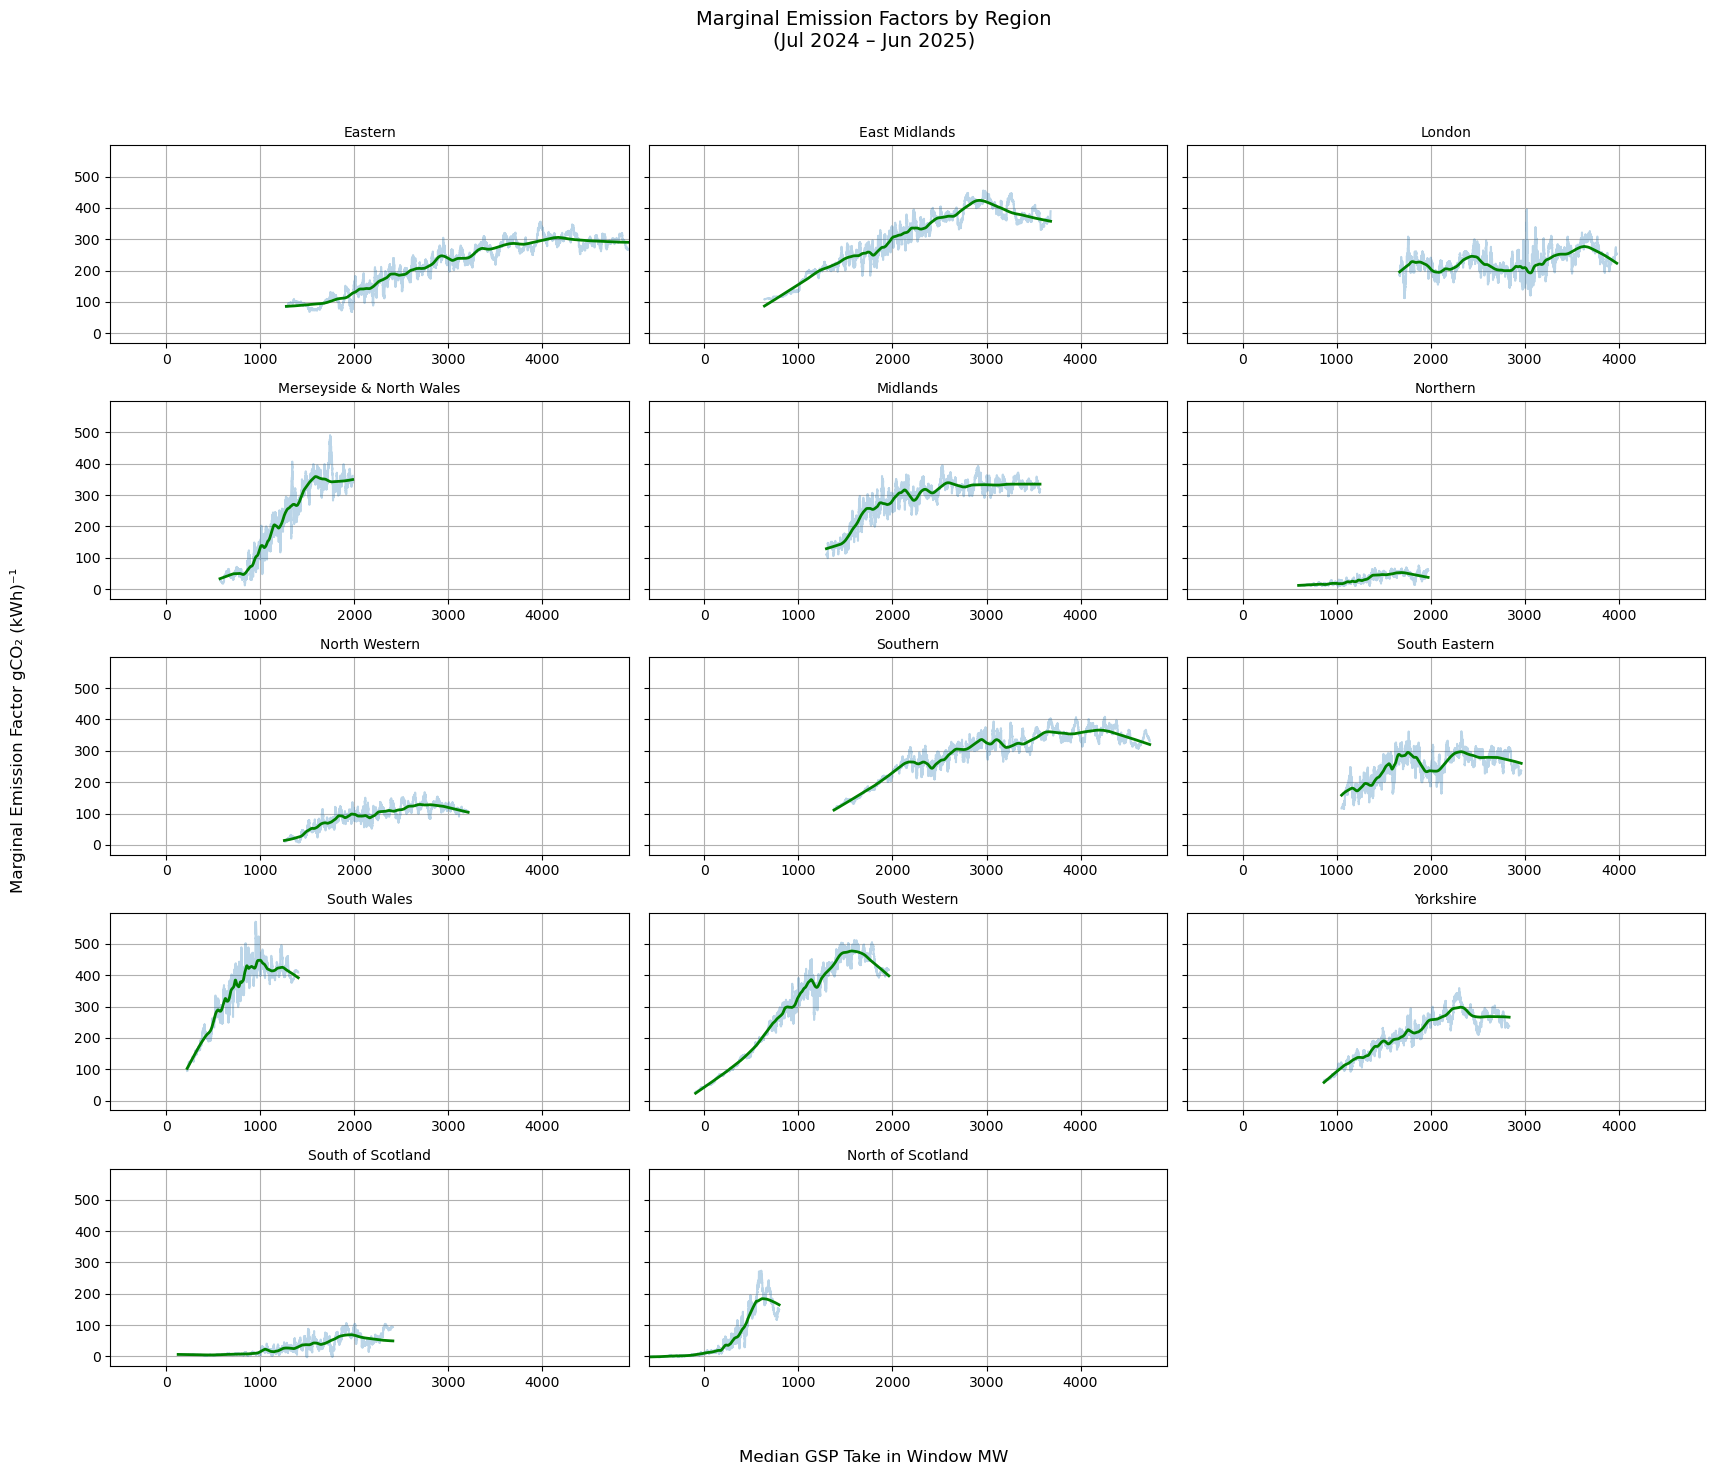

In [3]:
#This is the updated version that handles missing data better and also standardises the x-axis of plots
#runs in 2m 20s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort (DST-safe prep)
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)  # robust
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

# === Region codes and descriptions ===
region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# === Parameters ===
window_size = 200
lowess_frac = 0.1

# === Compute rolling slopes & medians per region (DST-safe forward diffs) ===
region_results = {}  # code -> (medians_array, slopes_array)

for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col not in df.columns or ci_col not in df.columns:
        print(f"Skipping {code} (columns missing)")
        continue

    # Bring in date/period and compute forward deltas (t -> t+1) with DST-safe consecutiveness
    region_df = df[['datetime', 'SettlementDate', 'SettlementPeriod', take_col, ci_col]].dropna().copy()
    region_df.rename(columns={take_col: 'Take', ci_col: 'CI'}, inplace=True)
    region_df = region_df.sort_values(['SettlementDate', 'SettlementPeriod'])

    region_df['CO2'] = region_df['Take'] * region_df['CI']

    # Identify true consecutive forward pairs (handles 46/48/50 SP days)
    region_df['next_date'] = region_df['SettlementDate'].shift(-1)
    region_df['next_sp']   = region_df['SettlementPeriod'].shift(-1)
    region_df['max_sp_today'] = region_df.groupby('SettlementDate')['SettlementPeriod'].transform('max')

    same_day_next = (
        (region_df['next_date'] == region_df['SettlementDate']) &
        (region_df['next_sp'] == region_df['SettlementPeriod'] + 1)
    )
    wrap_new_day = (
        (region_df['next_date'] != region_df['SettlementDate']) &
        (region_df['SettlementPeriod'] == region_df['max_sp_today']) &
        (region_df['next_sp'] == 1)
    )
    consecutive_forward = same_day_next | wrap_new_day

    # Forward differences aligned to t+1
    region_df['Δ_Take'] = region_df['Take'].shift(-1) - region_df['Take']
    region_df['Δ_CO2']  = region_df['CO2'].shift(-1) - region_df['CO2']

    # Keep only valid consecutive forward pairs
    region_df = region_df[consecutive_forward].dropna(subset=['Δ_Take', 'Δ_CO2', 'Take']).copy()
    region_df.rename(columns={'Take': 'Take_t'}, inplace=True)
    region_df = region_df.sort_values('Take_t').reset_index(drop=True)

    # Rolling OLS slopes of ΔCO2 on ΔTake vs. median Take_t in the window
    slopes, medians = [], []
    if len(region_df) >= window_size:
        for i in range(len(region_df) - window_size + 1):
            window = region_df.iloc[i:i + window_size]
            x = window['Δ_Take'].to_numpy().reshape(-1, 1)
            y = window['Δ_CO2'].to_numpy().reshape(-1, 1)
            reg = LinearRegression(fit_intercept=False).fit(x, y)
            slopes.append(reg.coef_[0, 0])
            medians.append(float(window['Take_t'].median()*2))

    if len(slopes) > 0:
        region_results[code] = (np.array(medians), np.array(slopes))
    else:
        print(f"Skipping {code} (insufficient consecutive data for rolling windows)")

# === Standardise x-axis across all subplots ===
if not region_results:
    raise RuntimeError("No region produced results. Check data availability and window_size.")

all_medians = np.concatenate([m for m, _ in region_results.values()])
x_min, x_max = np.min(all_medians), np.max(all_medians)

# === Plot with shared, standardised x-axis ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharey=True)
axes = axes.flatten()

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    if code not in region_results:
        ax.set_visible(False)
        continue

    medians, slopes = region_results[code]
    # LOWESS smoothing for display
    lowess_result = sm.nonparametric.lowess(slopes, medians, frac=lowess_frac)

    ax.plot(medians, slopes, alpha=0.3, label='Raw Slopes')
    ax.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='LOWESS')
    ax.set_title(region_descriptions[code], fontsize=10)
    ax.set_xlim(x_min, x_max)  # <- standardised x-axis
    ax.grid(True)

# Hide any unused subplot
for j in range(len(region_codes), len(axes)):
    axes[j].axis('off')

# Shared axis labels and title
fig.supxlabel('Median GSP Take in Window MW', fontsize=12)
fig.supylabel('Marginal Emission Factor gCO₂ (kWh)⁻¹', fontsize=12)
fig.suptitle('Marginal Emission Factors by Region\n(Jul 2024 – Jun 2025)', fontsize=14)

plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()




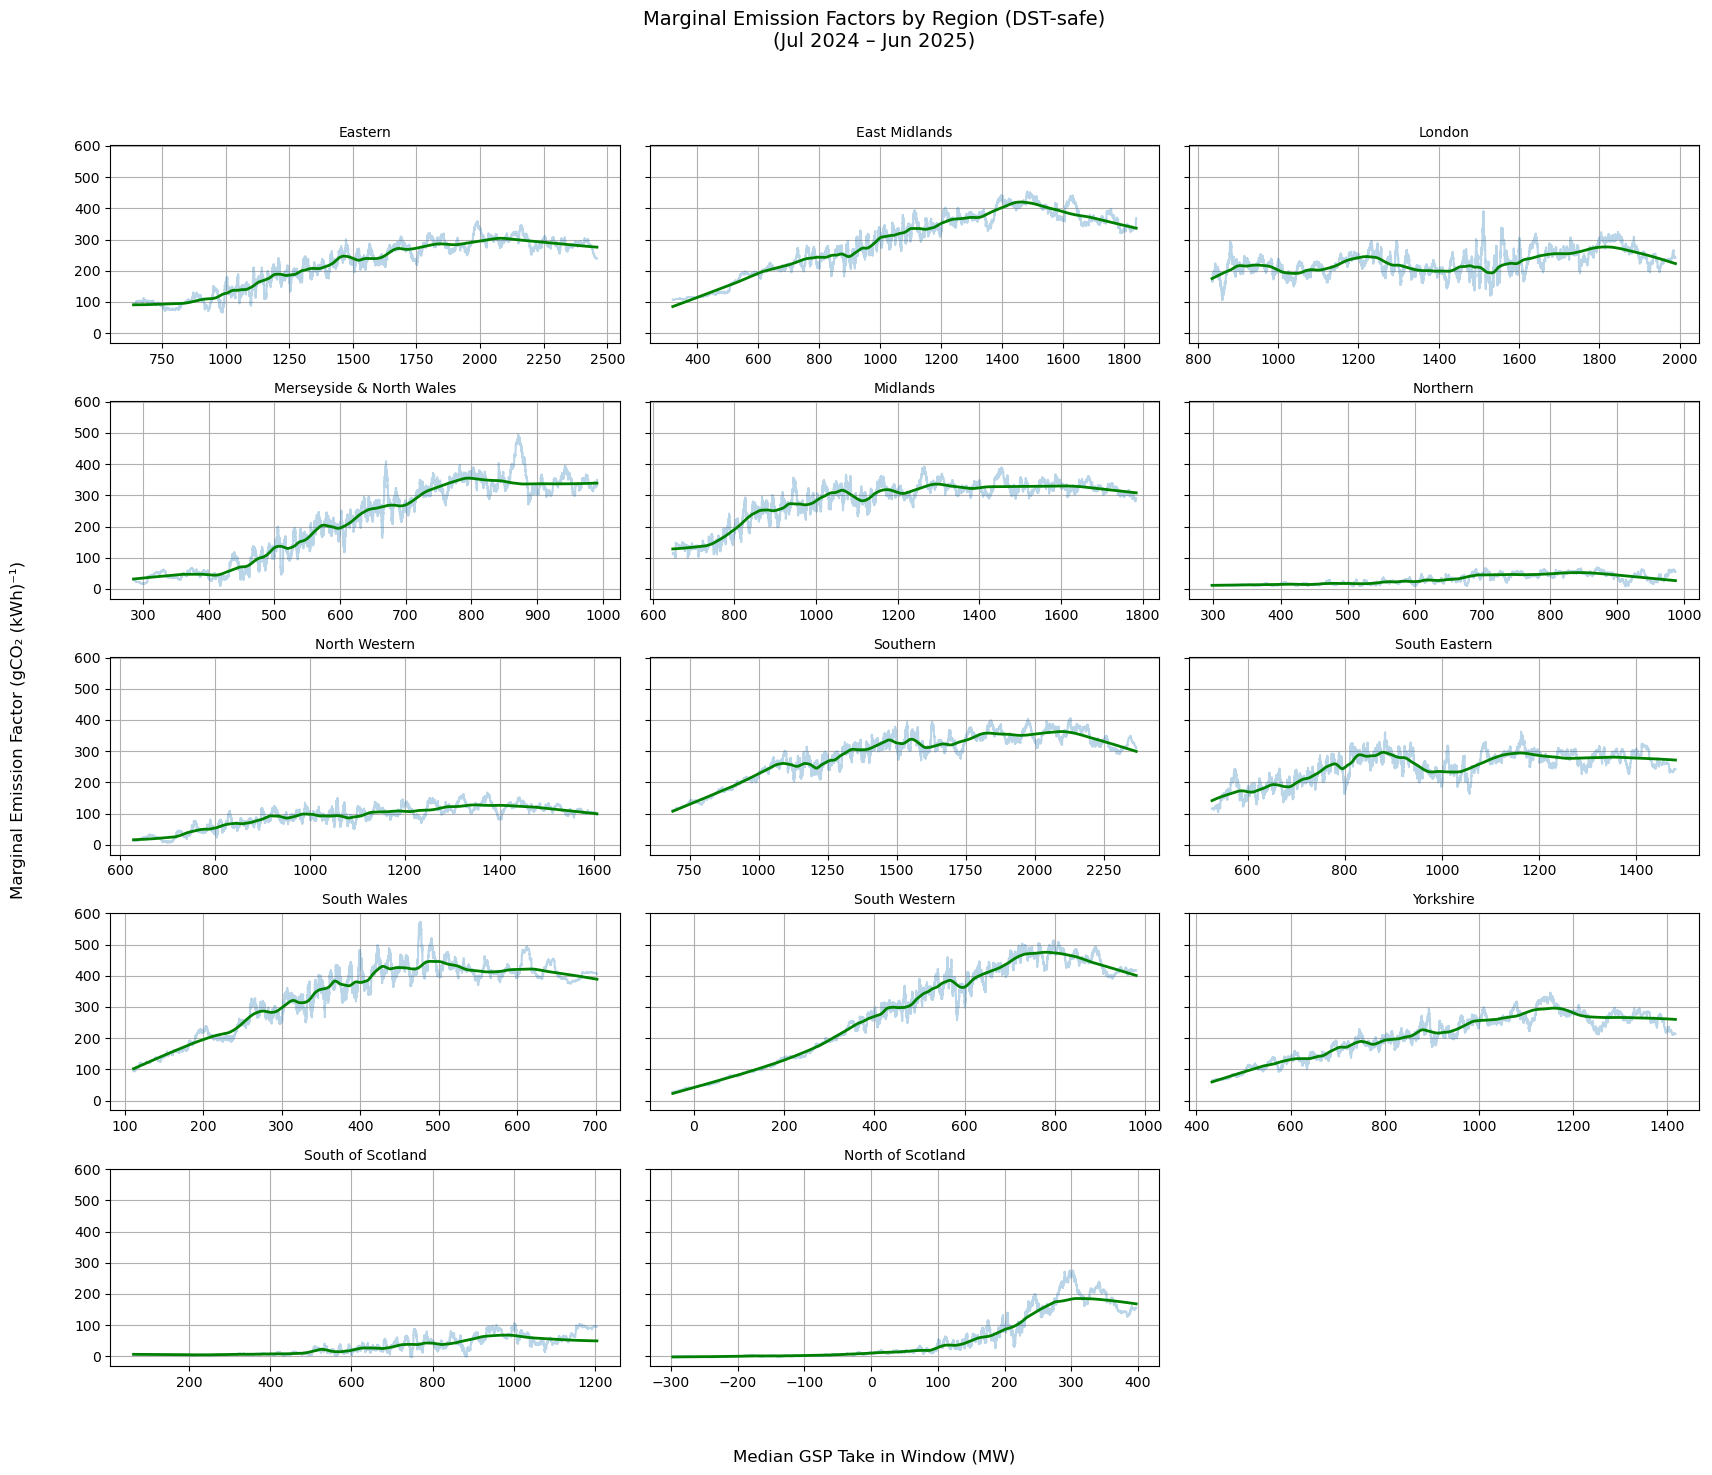

In [ ]:
#This is the updated version that handles missing data better
#2mins 50s
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)  # robust
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

# === Region codes and descriptions ===
region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# === Setup subplots ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharey=True)
axes = axes.flatten()

# === Loop through each region ===
window_size = 200

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'

    if take_col not in df.columns or ci_col not in df.columns:
        print(f"Skipping {code} (columns missing)")
        ax.set_visible(False)
        continue

    # Bring in date/period to handle DST correctly and compute forward deltas
    region_df = df[['datetime', 'SettlementDate', 'SettlementPeriod', take_col, ci_col]].dropna().copy()
    region_df = region_df.rename(columns={take_col: 'Take', ci_col: 'CI'})
    region_df = region_df.sort_values(['SettlementDate', 'SettlementPeriod'])

    # CO2 at time t
    region_df['CO2'] = region_df['Take'] * region_df['CI']

    # --- DST-safe consecutiveness to t+1 (forward) ---
    # Next row's date/period
    region_df['next_date'] = region_df['SettlementDate'].shift(-1)
    region_df['next_sp']   = region_df['SettlementPeriod'].shift(-1)

    # Max SP for the *current* day (can be 46/48/50)
    region_df['max_sp_today'] = region_df.groupby('SettlementDate')['SettlementPeriod'].transform('max')

    # True consecutive if: same day & SP_next = SP + 1, or wrap day & SP = max_today & SP_next = 1
    same_day_next = (
        (region_df['next_date'] == region_df['SettlementDate']) &
        (region_df['next_sp'] == region_df['SettlementPeriod'] + 1)
    )
    wrap_new_day = (
        (region_df['next_date'] != region_df['SettlementDate']) &
        (region_df['SettlementPeriod'] == region_df['max_sp_today']) &
        (region_df['next_sp'] == 1)
    )
    consecutive_forward = same_day_next | wrap_new_day

    # Forward differences aligned to t+1
    region_df['Δ_Take'] = region_df['Take'].shift(-1) - region_df['Take']
    region_df['Δ_CO2']  = region_df['CO2'].shift(-1) - region_df['CO2']

    # Keep only rows where t→t+1 is truly consecutive (DST-safe), then drop NaNs
    region_df = region_df[consecutive_forward].dropna(subset=['Δ_Take', 'Δ_CO2', 'Take']).copy()

    # 'Take_t' is the Take at time t (the window is sorted by this)
    region_df = region_df.rename(columns={'Take': 'Take_t'})

    # Sort by Take_t for rolling windows
    region_df = region_df.sort_values('Take_t').reset_index(drop=True)

    slopes = []
    medians = []

    # Rolling regressions over windows of size 'window_size'
    for i in range(len(region_df) - window_size + 1):
        window = region_df.iloc[i:i + window_size]
        x = window['Δ_Take'].values.reshape(-1, 1)
        y = window['Δ_CO2'].values.reshape(-1, 1)

        reg = LinearRegression().fit(x, y)
        slopes.append(reg.coef_[0][0])
        medians.append(window['Take_t'].median())

    if len(slopes) > 0:
        # LOWESS smoothing of the windowed slopes vs median Take_t
        lowess_result = sm.nonparametric.lowess(slopes, medians, frac=0.1)

        # Plot
        ax.plot(medians, slopes, alpha=0.3, label='Raw Slopes')
        ax.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='LOWESS')
        ax.set_title(region_descriptions[code], fontsize=10)
        ax.grid(True)
    else:
        ax.set_visible(False)

# Hide the unused 15th subplot
if len(axes) > len(region_codes):
    axes[-1].axis('off')

# Shared axis labels
fig.supxlabel('Median GSP Take in Window (MW)', fontsize=12)
fig.supylabel('Marginal Emission Factor (gCO₂ (kWh)⁻¹)', fontsize=12)

# Title and layout
fig.suptitle('Marginal Emission Factors by Region (DST-safe)\n(Jul 2024 – Jun 2025)', fontsize=14)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()


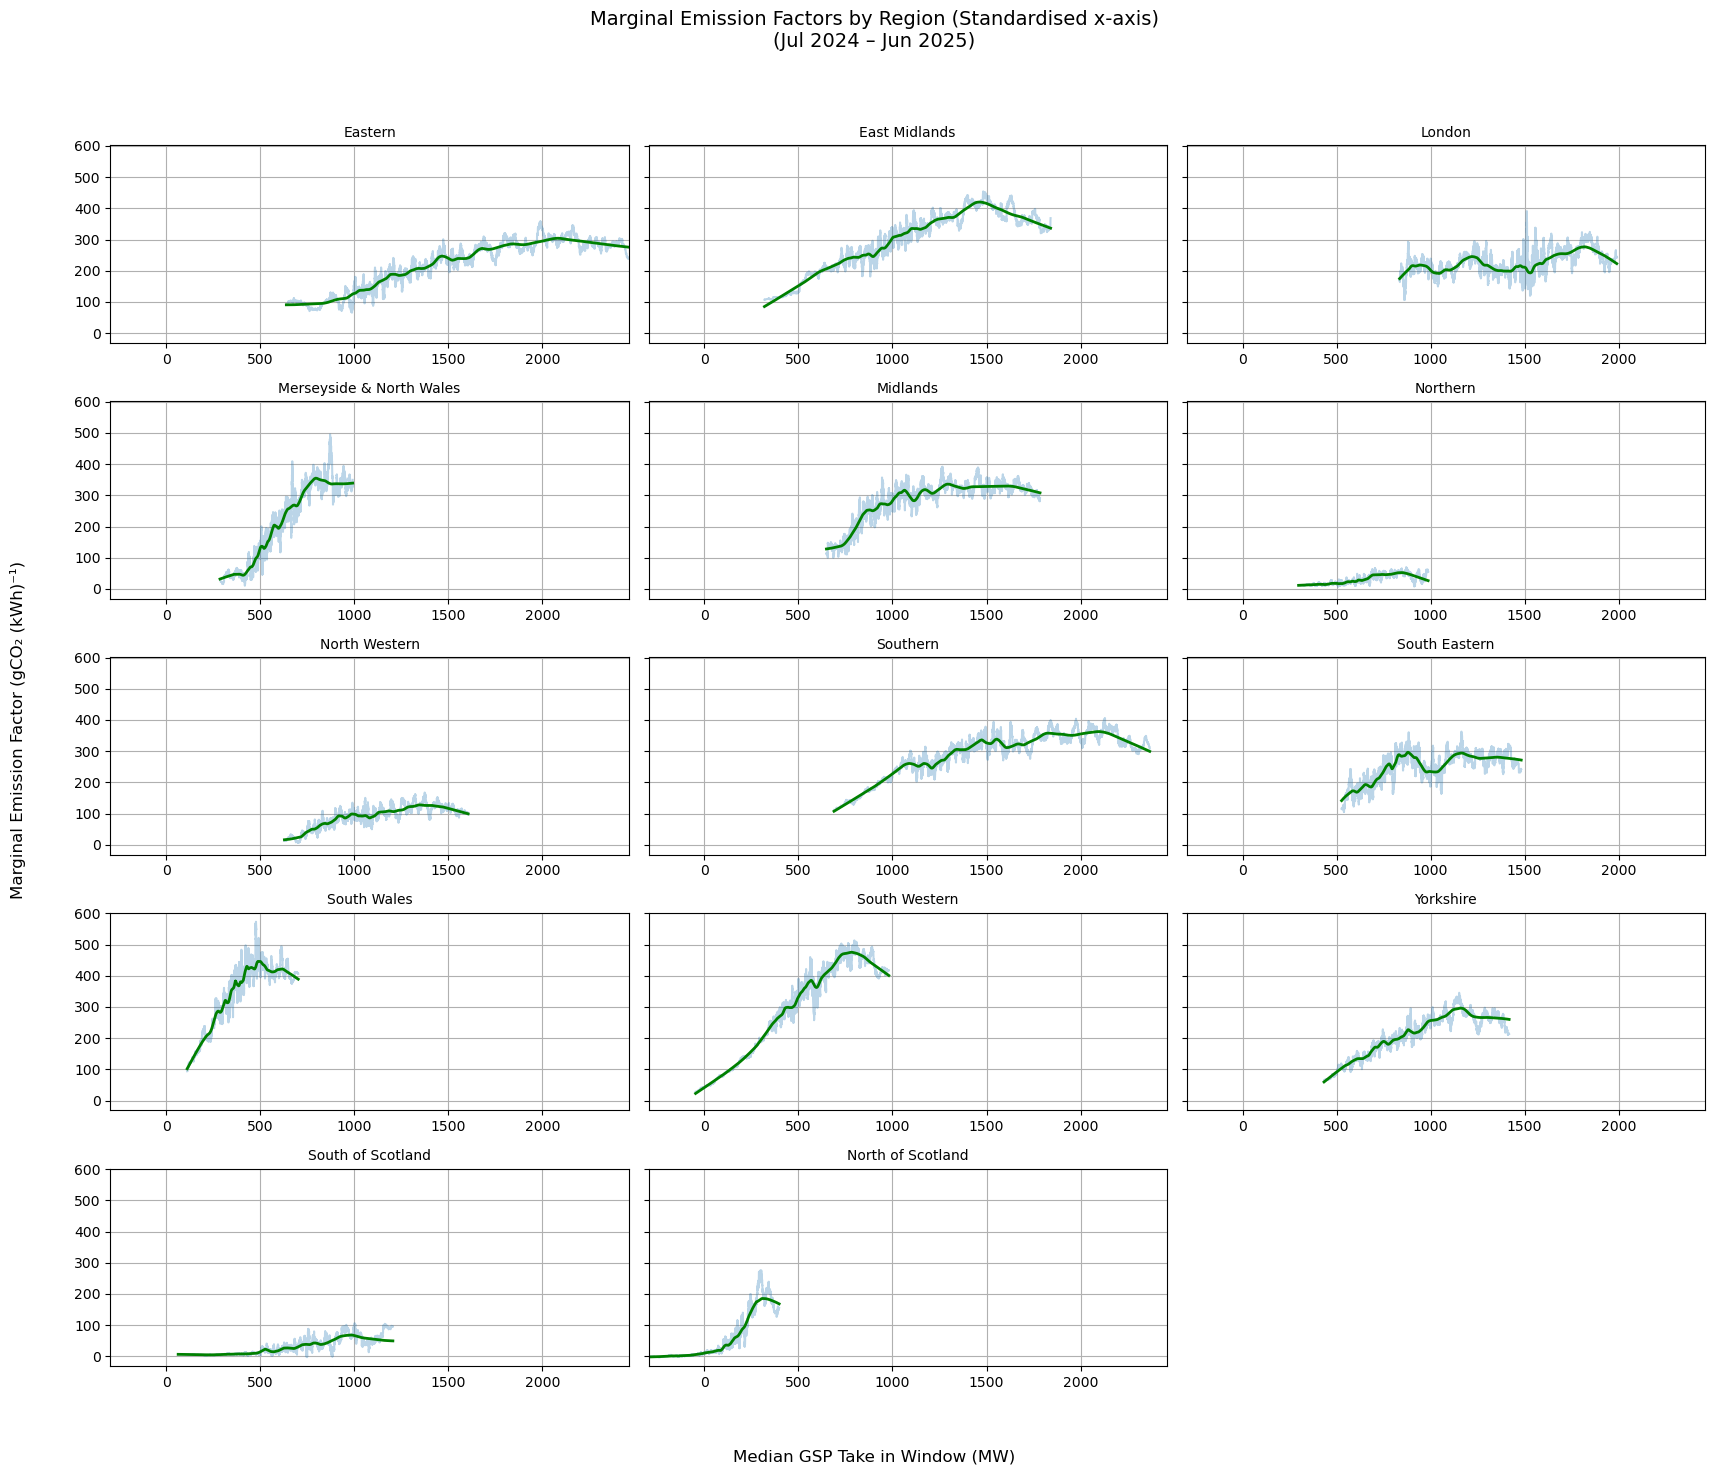

In [2]:
#just replots the above with standardised x axes

# === Recompute medians/slopes for all regions and store ===
region_results = {}

for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col not in df.columns or ci_col not in df.columns:
        continue

    region_df = df[['datetime', 'SettlementDate', 'SettlementPeriod', take_col, ci_col]].dropna().copy()
    region_df = region_df.rename(columns={take_col: 'Take', ci_col: 'CI'})
    region_df = region_df.sort_values(['SettlementDate', 'SettlementPeriod'])
    region_df['CO2'] = region_df['Take'] * region_df['CI']

    # DST-safe consecutiveness forward
    region_df['next_date'] = region_df['SettlementDate'].shift(-1)
    region_df['next_sp']   = region_df['SettlementPeriod'].shift(-1)
    region_df['max_sp_today'] = region_df.groupby('SettlementDate')['SettlementPeriod'].transform('max')

    same_day_next = (
        (region_df['next_date'] == region_df['SettlementDate']) &
        (region_df['next_sp'] == region_df['SettlementPeriod'] + 1)
    )
    wrap_new_day = (
        (region_df['next_date'] != region_df['SettlementDate']) &
        (region_df['SettlementPeriod'] == region_df['max_sp_today']) &
        (region_df['next_sp'] == 1)
    )
    consecutive_forward = same_day_next | wrap_new_day

    region_df['Δ_Take'] = region_df['Take'].shift(-1) - region_df['Take']
    region_df['Δ_CO2']  = region_df['CO2'].shift(-1) - region_df['CO2']

    region_df = region_df[consecutive_forward].dropna(subset=['Δ_Take', 'Δ_CO2', 'Take']).copy()
    region_df = region_df.rename(columns={'Take': 'Take_t'})
    region_df = region_df.sort_values('Take_t').reset_index(drop=True)

    slopes = []
    medians = []
    if len(region_df) >= window_size:
        for i in range(len(region_df) - window_size + 1):
            window = region_df.iloc[i:i + window_size]
            x = window['Δ_Take'].values.reshape(-1, 1)
            y = window['Δ_CO2'].values.reshape(-1, 1)
            reg = LinearRegression().fit(x, y)
            slopes.append(reg.coef_[0][0])
            medians.append(window['Take_t'].median())

        region_results[code] = (np.array(medians), np.array(slopes))

# === Find global x-axis range across all regions ===
all_medians = np.concatenate([m for m, s in region_results.values()])
x_min, x_max = np.min(all_medians), np.max(all_medians)

# === Replot with standardised x-axis ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharey=True)
axes = axes.flatten()

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    if code not in region_results:
        ax.set_visible(False)
        continue

    medians, slopes = region_results[code]
    if len(slopes) == 0:
        ax.set_visible(False)
        continue

    lowess_result = sm.nonparametric.lowess(slopes, medians, frac=0.1)
    ax.plot(medians, slopes, alpha=0.3, label='Raw Slopes')
    ax.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='LOWESS')
    ax.set_title(region_descriptions[code], fontsize=10)
    ax.set_xlim(x_min, x_max)  # standardised x-axis
    ax.grid(True)

# Hide unused subplot if any
for j in range(len(region_codes), len(axes)):
    axes[j].axis('off')

fig.supxlabel('Median GSP Take in Window (MW)', fontsize=12)
fig.supylabel('Marginal Emission Factor (gCO₂ (kWh)⁻¹)', fontsize=12)
fig.suptitle('Marginal Emission Factors by Region (Standardised x-axis)\n(Jul 2024 – Jun 2025)', fontsize=14)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()


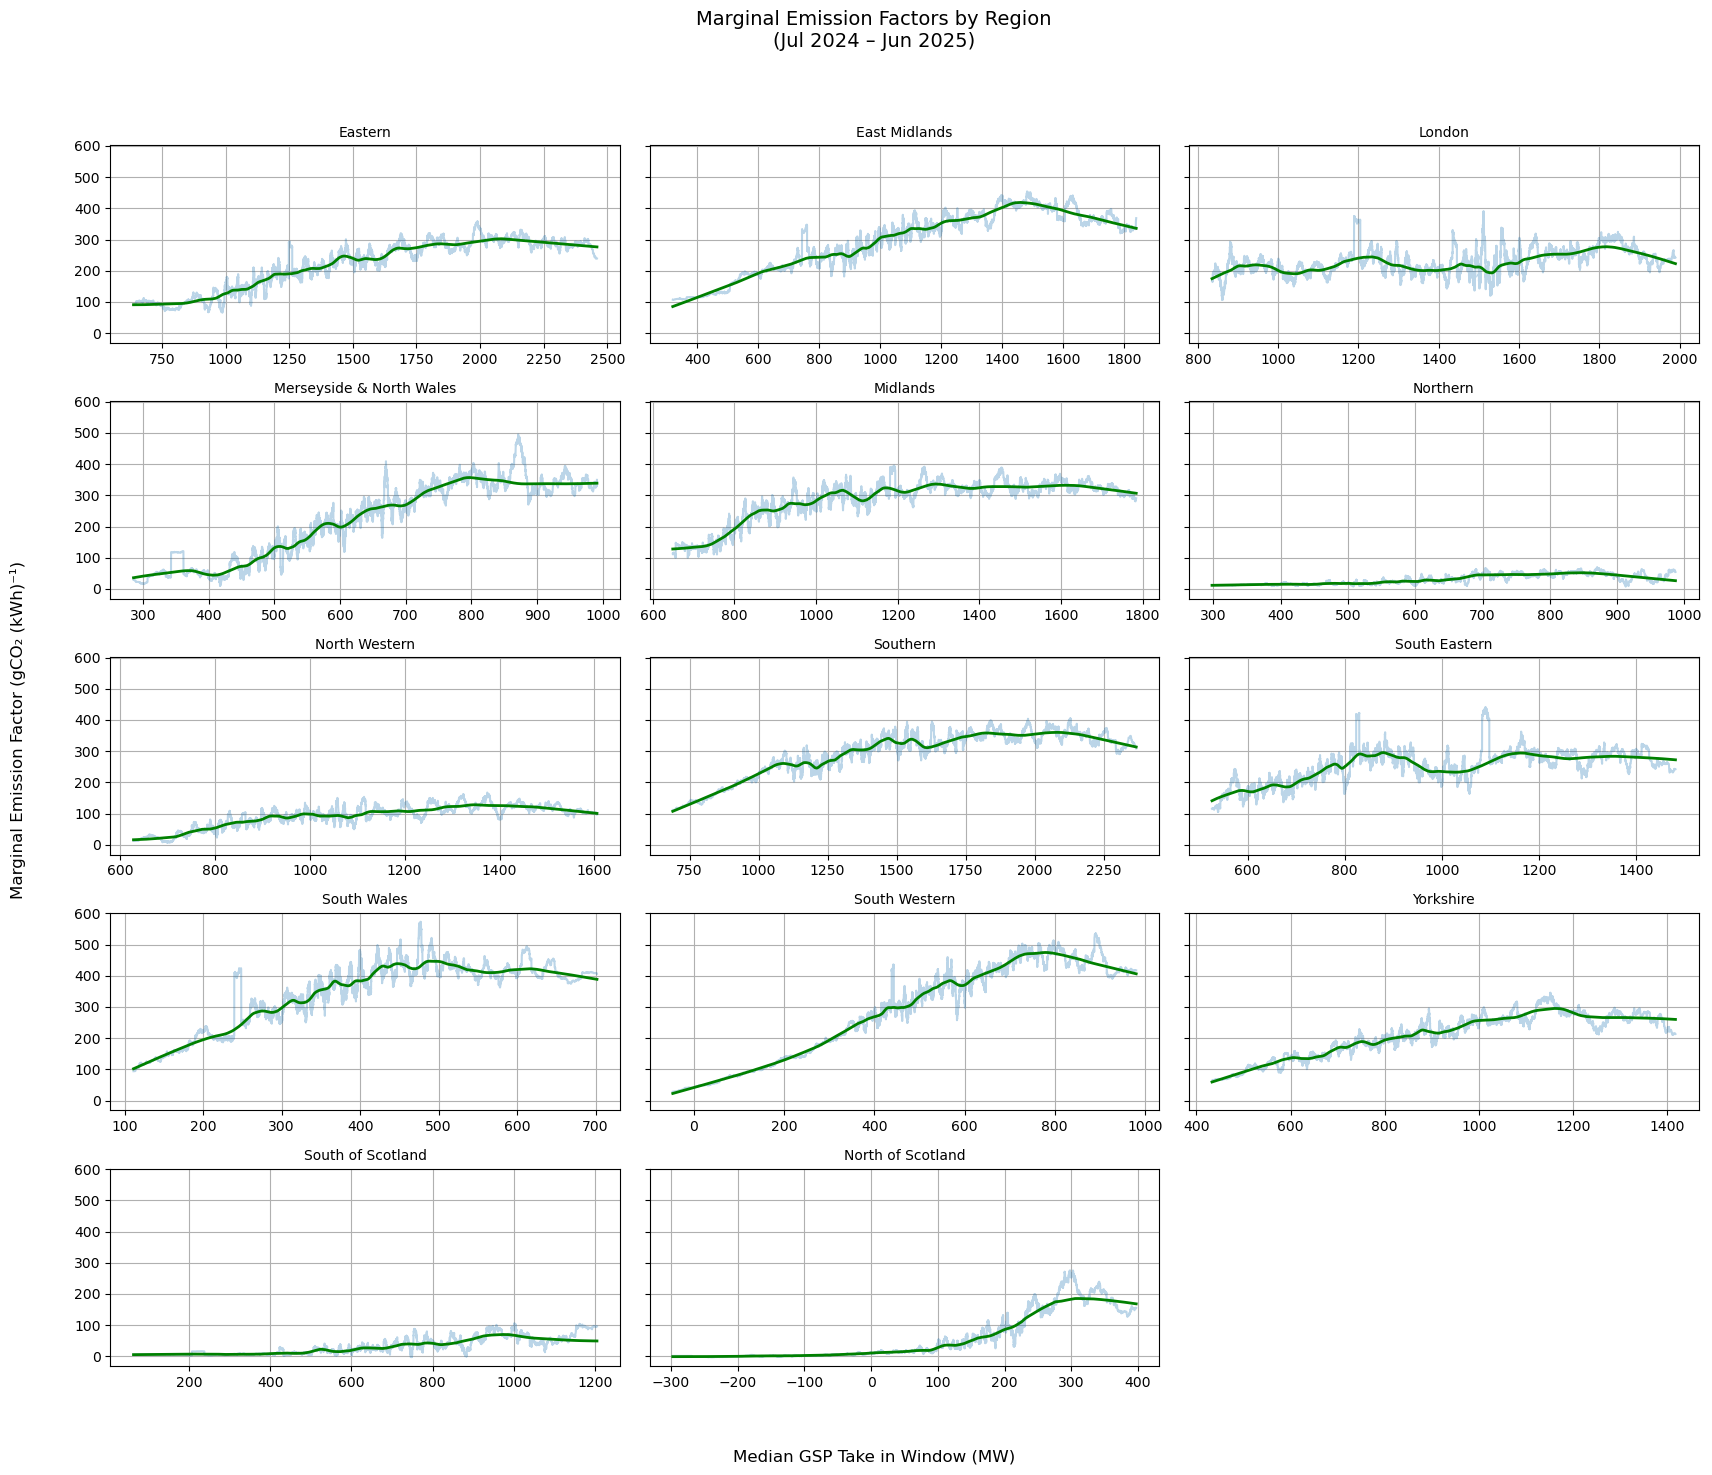

In [ ]:
#This is the original code - doesn't handle missing data perfectly (skips it, but allows for changes to be measured across missing data)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes and descriptions ===
region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# === Setup subplots ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharey=True)
axes = axes.flatten()

# === Loop through each region ===
window_size = 200

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    take_col = f'GSP_Take{code}'
    ci_col = f'CarbonIntensityForecast{code}'

    if take_col not in df.columns or ci_col not in df.columns:
        print(f"Skipping {code} (columns missing)")
        continue

    region_df = df[['datetime', take_col, ci_col]].dropna()

    # Rename for clarity
    region_df = region_df.rename(columns={take_col: 'Take', ci_col: 'CI'})
    region_df['CO2'] = region_df['Take'] * region_df['CI']

    # Align Take_t with deltas to t+1
    region_df['Δ_Take'] = region_df['Take'].diff().shift(-1)
    region_df['Δ_CO2'] = region_df['CO2'].diff().shift(-1)
    region_df = region_df.dropna(subset=['Take', 'Δ_Take', 'Δ_CO2']).copy()
    region_df = region_df.rename(columns={'Take': 'Take_t'})

    # Sort by Take_t
    region_df = region_df.sort_values('Take_t').reset_index(drop=True)

    slopes = []
    medians = []

    for i in range(len(region_df) - window_size + 1):
        window = region_df.iloc[i:i + window_size]
        x = window['Δ_Take'].values.reshape(-1, 1)
        y = window['Δ_CO2'].values.reshape(-1, 1)

        reg = LinearRegression().fit(x, y)
        slopes.append(reg.coef_[0][0])
        medians.append(window['Take_t'].median())

    if len(slopes) > 0:
        # LOWESS smoothing
        lowess_result = sm.nonparametric.lowess(slopes, medians, frac=0.1)

        # Plot
        ax.plot(medians, slopes, alpha=0.3, label='Raw Slopes')
        ax.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='LOWESS')
        ax.set_title(region_descriptions[code], fontsize=10)
        ax.grid(True)

# Hide the unused 15th subplot
if len(axes) > len(region_codes):
    axes[-1].axis('off')

# Shared axis labels
fig.supxlabel('Median GSP Take in Window (MW)', fontsize=12)
fig.supylabel('Marginal Emission Factor (gCO₂ (kWh)⁻¹)', fontsize=12)

# Title and layout
fig.suptitle('Marginal Emission Factors by Region\n(Jul 2024 – Jun 2025)', fontsize=14)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()
